# Image classification using CNN

## Load the data

In [35]:
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from os.path import join
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def loadCifarData(basePath):
    
    trainX = []
    testX = []
    trainY = []
    testY = []
    
    """Load training data"""
    for i in range(1, 6):
        with open(join(basePath, "data_batch_%d" %i), "rb") as f:
            dictionary = pickle.load(f, encoding = 'bytes')
            trainX.extend(dictionary[b'data'])
            trainY.extend(dictionary[b'labels'])
        
    with open(join(basePath, "test_batch"), "rb") as f:
        dictionary = pickle.load(f, encoding = 'bytes')
        testX.extend(dictionary[b'data'])
        testY.extend(dictionary[b'labels'])
            
    return trainX, trainY, testX, testY

def toImage(array, rows = 32, columns = 32):
    return array.reshape(3, rows, columns).transpose([1, 2, 0])

def toData(img, rows = 32, columns = 32):
    return img.transpose([-1, -2, 0]).flatten()

def plotImages(rows, columns, data, convert = True):
    fig, ax = plt.subplots(nrows=rows, ncols=columns)
    
    if rows == 1:
        ax = [ax]
    if columns == 1:
        ax = [ax]
        
    index = 0
    for row in ax:
        for col in row:
            if convert:
                col.imshow(toImage(data[index]))
            else:
                col.imshow(data[index])
            index = index + 1

In [36]:
trainRawX, trainRawY, testX, testY = loadCifarData("Data")

In [37]:
encoder = OneHotEncoder()
trainRawY = encoder.fit_transform(np.array(trainRawY).reshape(-1,1)).todense()

In [38]:
testY = encoder.transform(np.array(testY).reshape(-1,1)).todense()

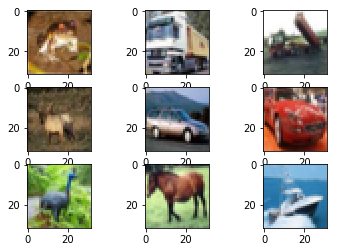

In [39]:
plotImages(3, 3, trainRawX)

## Data Augmentation

### Flip images

In [40]:
import numpy as np

def flipImage(srcImage):
    flippedImages = []
    flippedImages.append(np.fliplr(srcImage))
    flippedImages.append(np.flipud(srcImage))
    flippedImages.append(np.flipud(np.fliplr(srcImage)))
    return flippedImages

In [41]:
flipped = flipImage(toImage(trainRawX[1]))

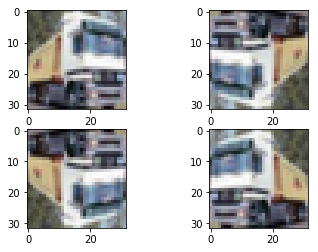

In [42]:
flipped.append(toImage(trainRawX[1]))
plotImages(2, 2, flipped, False)

### Change Brightness

In [43]:
import cv2

def changeBrightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    randomBrightness = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*randomBrightness
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

In [44]:
noisyImage = changeBrightness(toImage(trainRawX[1]))

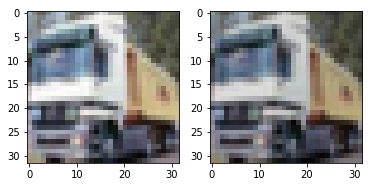

In [45]:
plotImages(1, 2, [toImage(trainRawX[1]), noisyImage], False)

### Augment Image

In [46]:
def augmentImage(imageVector):
    augmentedImages = []
    rawImages = []
    
    image = toImage(imageVector)
    flippedImages = flipImage(image)
    flippedImages.append(image)
    
    coinTossOutcome = np.random.binomial(1, 0.5, len(flippedImages))
    for img, toss in zip(flippedImages, coinTossOutcome):
        if toss == 1:
            img = changeBrightness(img)
        augmentedImages.append(img)
        rawImages.append(toData(img))
    return augmentedImages, rawImages

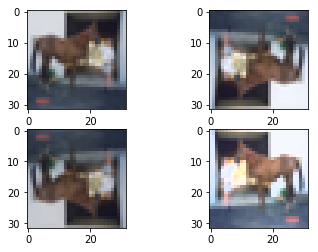

In [47]:
img, imgRaw = augmentImage(trainRawX[211])
plotImages(2, 2, img, False)

## Batch Data Iterator

In [48]:
from random import shuffle

def batchIterator(x, y, batchSize, batchCount):
    size = len(x)
    if batchSize * batchCount > size:
        raise ValueError("Change batch size or change batch count")
    
    indices = list(range(0, size))
    shuffle(indices)
    indices = indices[0:batchSize * batchCount]
    batches = np.array_split(indices, batchCount)
    for batch in batches:
        yield (x[batch], y[batch])

## Prepare data for training

In [49]:
trainX = []
trainY = []

for x, y in zip(trainRawX, trainRawY):
    rawAugmentedImages = augmentImage(x)[0]
    trainX.extend(rawAugmentedImages)
    target = [y for i in range(0, len(rawAugmentedImages))]
    trainY.extend(target)

In [50]:
print(len(trainRawX))
print(len(trainX))

50000
200000


In [51]:
print(trainRawY.shape)
print(len(trainY))

(50000, 10)
200000


In [52]:
trainX = np.stack(trainX, axis=0)
trainY = np.stack(trainY, axis=0)

In [53]:
processedTestX = []
processedTestY = []

for x, y in zip(testX, testY):
    processedTestY.append(y)
    processedTestX.append(toImage(x)) 

processedTestX = np.stack(processedTestX, axis=0)
processedTestY = np.stack(processedTestY, axis=0)

### Helper methods

In [54]:
def createConvolutionLayer(inputLayer, kernelHeight, kernelWidth, channelSize, kernelCount, strideX, strideY):
    """This will create a four dimensional tensor
    In this tensor the first and second dimension define the kernel height and width
    The third dimension define the channel size. If the input layer is 
    first layer in neural network then the channel size will be 3 in case of RGB images
    else 1 if images are grey scale. Furthermore if the input layer is Convolution layer 
    then the channel size should be no of kernels in previous layer"""
    weights = tf.Variable(tf.truncated_normal([kernelHeight, kernelWidth, channelSize, kernelCount], stddev=0.03))
    bias = tf.Variable(tf.constant(0.05, shape=[kernelCount]))
    
    """Stride is also 4 dimensional tensor
    The first and last values should be 1 as they represent the image index and 
    chanel size padding. Second and Third index represent the X and Y strides"""
    layer = tf.nn.conv2d(input = inputLayer, filter = weights, padding='SAME',
                        strides = [1, strideX, strideY, 1]) + bias
    return layer

In [55]:
def flattenLayer(inputLayer):
    """Flatten layer. The first component is image count which is useless"""
    flattenedLayer = tf.reshape(inputLayer, [-1, inputLayer.get_shape()[1:].num_elements()])
    return flattenedLayer

In [56]:
def fullyConnectedLayer(inputLayer, outputLayerCount):
    weights = tf.Variable(tf.truncated_normal(
                        [int(inputLayer.get_shape()[1]), outputLayerCount], stddev=0.03))
    bias = tf.Variable(tf.constant(0.05, shape=[outputLayerCount]))
    layer = tf.matmul(inputLayer, weights) + bias
    return layer

In [57]:
def log_histogram(writer, tag, values, step, bins=1000):
    # Convert to a numpy array
    values = np.array(values)

    # Create histogram using numpy
    counts, bin_edges = np.histogram(values, bins=bins)

    # Fill fields of histogram proto
    hist = tf.HistogramProto()
    hist.min = float(np.min(values))
    hist.max = float(np.max(values))
    hist.num = int(np.prod(values.shape))
    hist.sum = float(np.sum(values))
    hist.sum_squares = float(np.sum(values**2))

    # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
    # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
    # Thus, we drop the start of the first bin
    bin_edges = bin_edges[1:]

    # Add bin edges and counts
    for edge in bin_edges:
        hist.bucket_limit.append(edge)
    for c in counts:
        hist.bucket.append(c)

    # Create and write Summary
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
    writer.add_summary(summary, step)
    writer.flush()

### Define model

In [58]:
"""Input is 4 dimensional tensor -1 so that the no of images can be infered on itself"""
inputLayer = tf.placeholder(tf.float32, [None, 32, 32, 3])
yTrue = tf.placeholder(tf.float32, shape=[None, 10])

convolutionLayer1 = createConvolutionLayer(inputLayer, 2, 2, 3, 25, 1, 1)
reluActivatedLayer1 = tf.nn.relu(convolutionLayer1)
poolingLayer1 = tf.nn.max_pool(value=reluActivatedLayer1, ksize=[1, 1, 2, 1], strides = [1, 1, 1, 1], padding='SAME')
flattened = flattenLayer(poolingLayer1)
fc1 = fullyConnectedLayer(flattened, 850)
reluActivatedLayer2 = tf.nn.relu(fc1)
fc = fullyConnectedLayer(fc1, 10)

### Define Predictions

In [59]:
predictions = tf.argmax(tf.nn.softmax(fc), axis = 1)
actual = tf.argmax(yTrue, axis = 1)

### Define loss function and specify the optimizer

In [60]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc, labels = yTrue)

In [61]:
costFunction = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(costFunction)

In [62]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, actual), tf.float32))

### Create session and initialize global variables

In [63]:
session = tf.Session()
"""Initialize the global variables"""
session.run(tf.global_variables_initializer())

In [64]:
summaryWriter =  tf.summary.FileWriter("tensorboard/structure1/logs", graph=tf.get_default_graph())
trainAccList = []
testAccList = []
for i in range(0, 50):
    print("Epoch"+str(i))
    summary = tf.Summary()
    
    for x, y in batchIterator(trainX, trainY, 500, 50):
        session.run(optimizer, feed_dict={inputLayer:x, yTrue:y})
    
    loss = session.run(costFunction, feed_dict={inputLayer:x, yTrue:y})
    acc = session.run(accuracy, feed_dict={inputLayer:x, yTrue:y})    
    summary.value.add(tag = "TrainingLoss", simple_value = loss)
    summary.value.add(tag = "TrainingAcc", simple_value = acc)
    trainAccList.append(acc)
        
    lossTestList = []
    accTestList = []
    for x, y in batchIterator(processedTestX, processedTestY, 1000, 5):
        lossTest = session.run(costFunction, feed_dict={inputLayer:x, yTrue:y})
        accTest = session.run(accuracy, feed_dict={inputLayer:x, yTrue:y})
        lossTestList.append(lossTest)
        accTestList.append(accTest)
    summary.value.add(tag = "TestLoss", simple_value = np.mean(lossTestList))
    summary.value.add(tag = "TestAcc", simple_value = np.mean(accTestList))
    testAccList.append(np.mean(accTestList))
    summaryWriter.add_summary(summary, i)

Epoch0
Epoch1
Epoch2
Epoch3
Epoch4
Epoch5
Epoch6
Epoch7
Epoch8
Epoch9
Epoch10
Epoch11
Epoch12
Epoch13
Epoch14
Epoch15
Epoch16
Epoch17
Epoch18
Epoch19
Epoch20
Epoch21
Epoch22
Epoch23
Epoch24
Epoch25
Epoch26
Epoch27
Epoch28
Epoch29
Epoch30
Epoch31
Epoch32
Epoch33
Epoch34
Epoch35
Epoch36
Epoch37
Epoch38
Epoch39
Epoch40
Epoch41
Epoch42
Epoch43
Epoch44
Epoch45
Epoch46
Epoch47
Epoch48
Epoch49


In [65]:
log_histogram(summaryWriter, "TrainAccHist", trainAccList, 50)
log_histogram(summaryWriter, "TestAccHist", testAccList, 50)

In [66]:
session.close()

In [70]:
testAccList

[0.13800001,
 0.2232,
 0.24280003,
 0.2718,
 0.3088,
 0.3292,
 0.3442,
 0.33059996,
 0.34960002,
 0.34759998,
 0.3594,
 0.38219997,
 0.36140004,
 0.37739998,
 0.39540002,
 0.3664,
 0.39279997,
 0.3796,
 0.4028,
 0.3934,
 0.386,
 0.3926,
 0.3936,
 0.40819997,
 0.3962,
 0.4056,
 0.41079998,
 0.42339998,
 0.4306,
 0.3906,
 0.389,
 0.4032,
 0.42020002,
 0.43199998,
 0.42360002,
 0.4244,
 0.42740002,
 0.43800002,
 0.4296,
 0.42,
 0.44700003,
 0.4302,
 0.448,
 0.4428,
 0.4334,
 0.45380002,
 0.44240004,
 0.4526,
 0.4322,
 0.4492]